In [1]:
""" ---------------------------------------------------------------------------
                             Annual data analyses

- This code produce the figures and data for the annual analyses. 

"""
"""----------------------------------------------------------------------------
Importing libraries used in this script
----------------------------------------------------------------------------"""
""" ---------------------------------------------------------------------------
defining functions used in this script
----------------------------------------------------------------------------"""




from logging import PercentStyle
from matplotlib.pyplot import savefig
from numpy.random import sample
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from matplotlib.pylab import savefig as save
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn
import statsmodels.api as sm
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from statsmodels.stats.outliers_influence import summary_table
from xarray.core.duck_array_ops import count
def outliers_index(data, m=3.5):
    """
    Returns true if a value is outlier

    :param int data: numpy array
    :param int m: # of std to include data 
    """
    import numpy as np
    d = np.abs(data - np.nanmedian(data))
    mdev = np.nanmedian(d)
    s = d / mdev if mdev else 0.
    return ~(s < m)


def bootstrap(x, y, sample_weights, n, seed):
    """Bootstraping the weighted linear regression
        """
    np.random.seed(seed)
    # add a column of ones
    X = np.vstack([x, np.ones(len(x))]).T
    predicts = []
    params = []
    for j in range(0, n):
        sample_index = np.random.choice(range(0, len(y)), len(y))
        X_samples = X[sample_index]
        y_samples = y[sample_index]
        w_samples = sample_weights[sample_index]
        mod_wls = sm.WLS(y_samples, X_samples, weights=w_samples)
        res_wls = mod_wls.fit()
        predict = res_wls.predict(X)
        par = np.round(res_wls.params, 3)
        predicts.append(predict)
        params.append(par)
    predicts = np.array(predicts).T
    params = np.array(params).T
    return params, predicts


def binning(df, bins, var):
    """
    Fit OLS between variable of interest and DLCC

    :param dataframe df: pandas dataframe
    :param int bins: similar to bins argument in pandas.cut (bins intervals)
    :param str var: variable of interest   
    """
    # Binning data based on bins intervals
    df["bins"] = pd.cut(df["dlcc"], bins=bins, include_lowest=True)
    # group data based on bins and get the weighted mean of each bin
    bins_mean = df.groupby('bins').mean()

    # uncomment following linesto set the threshold on minimum number
    # of data in each bin since our bins are very small (0.001) we did not set
    counts = df.groupby('bins').count()["dlcc"]
    # bins_mean = bins_mean.where(counts >= 5)

    # Get rid of bins when there is zero data
    x = bins[1:][bins_mean[var].notnull()]
    y = bins_mean[var][bins_mean[var].notnull()].values
    counts = counts[bins_mean[var].notnull()]

    # X = sm.add_constant(x)
    # # Note it is weighted regression
    # mod_ols = sm.WLS(y, X, weights=counts)
    # res_ols = mod_ols.fit()
    # intercept, slope = np.round(res_ols.params, 3)

    # uncomment following linesto set the threshold on minimum number
    # of data in each bin since our bins are very small (0.001) we did not set
    # counts = df.groupby('bins').count()["dlcc"]
    # bins_mean = bins_mean.where(counts > 10)

    # intercept, slope = np.round(res_ols.params, 3)
    # intercept_bse, slope_bse = np.round(res_ols.bse, 3)
    # predicts = res_ols.predict(X)
    # pvalues = res_ols.pvalues
    # st, data, ss2 = summary_table(res_ols, alpha=0.05)
    # predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    out_list = [x, y, counts]
    return out_list


class ScalarFormatterForceFormat(ScalarFormatter):

    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here


yfmt = ScalarFormatterForceFormat()
yfmt.set_powerlimits((0, 0))
N_M = 10000  # Number of bootstrap
in_dir = ("/data/home/hamiddashti/nasa_above/outputs/")
out_dir = ("/data/home/hamiddashti/nasa_above/outputs/data_analyses/Annual/"
           "Albers/Figures_MS1/")

# out_dir = (
#     "/data/home/hamiddashti/mnt/nasa_above/working/modis_analyses/test/")

# The map of dLST due to LCC
# dlst_lcc = xr.open_dataarray(
#     in_dir + ("Natural_Variability/Natural_Variability_Annual_outputs/Albers/"
#               "dlst_lcc.nc"))
# dlst_total = xr.open_dataarray(
#     in_dir + ("Natural_Variability/Natural_Variability_Annual_outputs/Albers/"
#               "dlst_total.nc"))

# This is the results of confusion table script
ct = xr.open_dataset(
    in_dir + "Sensitivity/EndPoints/Annual/Albers/Confusion_Table_Albers.nc")

dlst = ct["DLST_MEAN_LCC"]  # Changed LST due to LCC
# weights = ct["WEIGHTS"]  # Weights based on area
# weights = xr.Variable("ID", np.ones(len(dlst)))  # All weights are one
det = ct["DET_LCC"]  # Changed ET due to LCC
dalbedo = ct["DALBEDO_LCC"]  # Changed albedo due to LCC
dlcc = ct["DLCC"]  # Fractional change in land cover
normalized_confusion = ct["NORMALIZED_CONFUSION"]  # Normalized confusion
I_dlst = outliers_index(dlst, 3.5)  # Outlier indices for dLST
I_dalbedo = outliers_index(dalbedo, 3.5)  # Outlier indices for dalbedo
I_det = outliers_index(det, 3.5)  # Outlier indices for det

# Remove outliers based on indices
dlst_clean = dlst.where((I_dlst == False) & (I_dalbedo == False)
                        & (I_det == False))
dalbedo_clean = dalbedo.where((I_dlst == False) & (I_dalbedo == False)
                              & (I_det == False))
det_clean = det.where((I_dlst == False) & (I_dalbedo == False)
                      & (I_det == False))

# weights_clean = weights.where(I_dlst == False)
# dlcc_clean = dlcc.where((I_dlst == False) & (I_dalbedo == False)
#                         & (I_det == False))
# normalized_confusion_clean = normalized_confusion.where((I_dlst == False)
#                                                         & (I_dalbedo == False)
#                                                         & (I_det == False))

dlcc_clean = dlcc
normalized_confusion_clean = normalized_confusion

palette = sns.color_palette("tab10")  # Color palette for plots
lc_names = [
    "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen", "Bog",
    "Shallow_Littoral", "Water"
]

Analyzing EF
Analyzing DF
Analyzing Shrub
Analyzing Herbaceous
Analyzing Sparse
Analyzing Barren
Analyzing Fen


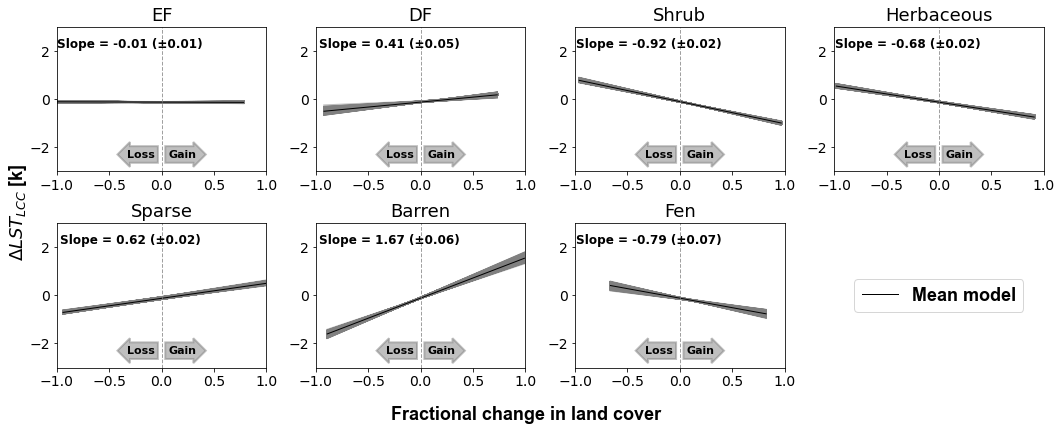

In [2]:
# Figure 2 of the manuscript (Main LST plot)
plt.close()
fig, axs = plt.subplots(2, 4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs_counter = 0
t_list = []

for i in range(len(lc_names)):
    # Skip the bog and shallow and litteral classes due to very sparse
    # data points
    if (i == 7) | (i == 8) | (i == 9):
        continue
    print(f"Analyzing {lc_names[i]}")
    dlcc_tmp_clean = dlcc_clean.isel(LC=i)
    df = pd.DataFrame({
        "dlst": dlst_clean,
        "dalbedo": dalbedo_clean,
        "det": det_clean,
        # "w": weights_clean,
        "dlcc": dlcc_tmp_clean
    })
    df = df.dropna()
    # ----------------------------------------------
    # Bin data based on dLCC
    dlcc_bins = np.linspace(-1.001, 1, 2002)
    gian_loss_bins = binning(df=df, bins=dlcc_bins, var="dlst")
    # Scatter plot of the gain/loss
    # axs[axs_counter].scatter(x=out[0], y=out[1], color="gray")
    x = gian_loss_bins[0]
    y = gian_loss_bins[1]
    sample_weights = gian_loss_bins[2].values
    boot_reg = bootstrap(x=x,
                         y=y,
                         sample_weights=sample_weights,
                         n=N_M,
                         seed=0)
    params = boot_reg[0]
    predicts = boot_reg[1]
    axs[axs_counter].plot(x, predicts, color="gray", alpha=0.5)
    mean_predicts = np.mean(predicts, axis=1)
    axs[axs_counter].plot(x,
                          mean_predicts,
                          color="black",
                          linewidth=1,
                          label='Mean model')
    slope_mean = np.round(params[0, ].mean(), 2)
    slope_std = np.round(params[0, ].std(), 2)
    intercept_mean = np.round(params[1, ].mean(), 2)
    intercept_std = np.round(params[1, ].std(), 2)
    # if slope_mean > 0:
    #     eq_text = (f"Slope = {slope_mean}" + "(\u00B1" +
    #                f"{slope_std})")
    # else:
    eq_text = (f"Slope = {slope_mean}" + " (\u00B1" +
                f"{slope_std})")
    axs[axs_counter].set_title(lc_names[i],fontsize=18)
    axs[axs_counter].tick_params(labelsize=14)
    axs[axs_counter].axvline(0, ls='--', c="gray", linewidth=1,alpha=0.75)
    axs[axs_counter].text(-0.30,
                          2.3,
                          eq_text,
                          horizontalalignment='center',
                          verticalalignment='center',
                          fontsize=12,
                          fontweight="bold",
                          color="black")
    axs[axs_counter].set_xlim(-1, 1)
    axs[axs_counter].set_ylim(-3, 3)
    axs[axs_counter].text(0.20,
                          -2.3,
                          "Gain",
                          ha="center",
                          va="center",
                          size=11,
                          fontweight="semibold",
                          color="black",
                          bbox=dict(boxstyle="rarrow,pad=0.3",
                                    fc="gray",
                                    ec="gray",
                                    alpha=0.5,
                                    lw=2))
    axs[axs_counter].text(-0.20,
                          -2.3,
                          "Loss",
                          ha="center",
                          va="center",
                          size=11,
                          fontweight="semibold",
                          color="black",
                          bbox=dict(boxstyle="larrow,pad=0.3",
                                    fc="gray",
                                    ec="gray",
                                    alpha=0.5,
                                    lw=2))
    axs[axs_counter].set_xlim(-1, 1)
    axs[axs_counter].set_ylim(-3, 3)
    # Now plot class transitions on top of the gain/loss
    # for k in range(2):
    axs_counter += 1

# Sorting out the legend
labels_handles = {
    label: handle
    for ax in fig.axes
    for handle, label in zip(*ax.get_legend_handles_labels())
}

# desired_legend_order = [
#     "Mean model", "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen"
# ]
# reordered_labels_handles = {k: labels_handles[k] for k in desired_legend_order}
# plt.legend(
#     reordered_labels_handles.values(),
#     reordered_labels_handles.keys(),
#     bbox_to_anchor=(1, 1),
# )
bottom_right_ax = axs[-1]
bottom_right_ax.clear()  # clears the random data I plotted previously
bottom_right_ax.set_axis_off()  # removes the XY axes

leg = plt.legend(
    labels_handles.values(),
    labels_handles.keys(),
    # bbox_to_anchor=(1, 1),
    loc='center',
    prop={
        "family": "Arial",
        "weight": "bold",
        "size": 18
    },
)

# for legobj in leg.legendHandles:
#     legobj.set_linewidth(2.0)
#     legobj.set_color("red")
#     legobj.set_alpha(1)

pltfont = {'fontname': 'Arial'}
fig.supxlabel('Fractional change in land cover', fontsize=18,fontweight="bold", **pltfont)
fig.supylabel("$\Delta LST_{LCC}$ [k]", fontsize=18,fontweight="bold", **pltfont)
# fig.suptitle("A", x=0.02, y=0.85, size=30, **pltfont)
plt.tight_layout()
save(out_dir + "Annual_gain_loss_LST_Albers_CI_After_ERL_Revision.png")


Analyzing EF
Analyzing DF
Analyzing Shrub
Analyzing Herbaceous
Analyzing Sparse
Analyzing Barren
Analyzing Fen


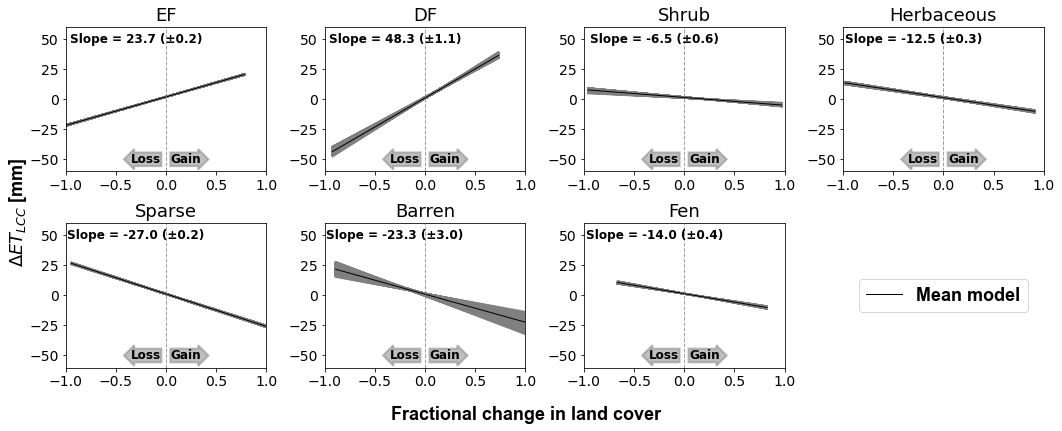

In [3]:
plt.close()
fig, axs = plt.subplots(2, 4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs_counter = 0
t_list = []
for i in range(len(lc_names)):
    # Skip the bog and shallow and litteral classes due to very sparse
    # data points
    if (i == 7) | (i == 8) | (i == 9):
        continue
    print(f"Analyzing {lc_names[i]}")
    dlcc_tmp_clean = dlcc_clean.isel(LC=i)
    df = pd.DataFrame({
        "dlst": dlst_clean,
        "dalbedo": dalbedo_clean,
        "det": det_clean,
        # "w": weights_clean,
        "dlcc": dlcc_tmp_clean
    })
    df = df.dropna()
    # Bin data based on dLCC
    dlcc_bins = np.linspace(-1.001, 1, 2002)
    gian_loss_bins = binning(df=df, bins=dlcc_bins, var="det")
    x = gian_loss_bins[0]
    y = gian_loss_bins[1]
    sample_weights = gian_loss_bins[2].values
    boot_reg = bootstrap(x=x,
                         y=y,
                         sample_weights=sample_weights,
                         n=N_M,
                         seed=0)
    params = boot_reg[0]
    predicts = boot_reg[1]
    axs[axs_counter].plot(x, predicts, color="gray", alpha=0.5)
    mean_predicts = np.mean(predicts, axis=1)
    axs[axs_counter].plot(x,
                          mean_predicts,
                          color="black",
                          linewidth=1,
                          label='Mean model')
    slope_mean = np.round(params[0, ].mean(), 1)
    slope_std = np.round(params[0, ].std(), 1)
    intercept_mean = np.round(params[1, ].mean(), 1)
    intercept_std = np.round(params[1, ].std(), 1)
    eq_text = (f"Slope = {slope_mean}" + " (\u00B1" +
                f"{slope_std})")
    axs[axs_counter].set_title(lc_names[i],fontsize=18)
    axs[axs_counter].tick_params(labelsize=14)
    axs[axs_counter].axvline(0, ls='--', c="gray", linewidth=1,alpha=0.75)
    axs[axs_counter].text(-0.3,
                          50,
                          eq_text,
                          horizontalalignment='center',
                          verticalalignment='center',
                          fontsize=12,
                          fontweight="bold",
                          color="black")
    axs[axs_counter].text(0.2,
                          -50,
                          "Gain",
                          ha="center",
                          va="center",
                          size=12,
                          color="black",
                          fontweight = "semibold",
                          bbox=dict(boxstyle="rarrow,pad=0.03",
                                    fc="gray",
                                    ec="gray",
                                    alpha=0.5,
                                    lw=2))
    axs[axs_counter].text(-0.2,
                          -50,
                          "Loss",
                          ha="center",
                          va="center",
                          size=12,
                          fontweight = "semibold",
                          color="black",
                          bbox=dict(boxstyle="larrow,pad=0.03",
                                    fc="gray",
                                    ec="gray",
                                    alpha=0.5,
                                    lw=2))
    axs[axs_counter].set_xlim(-1, 1)
    axs[axs_counter].set_ylim(-60, 60)
    axs_counter += 1

# Sorting out the legend
labels_handles = {
    label: handle
    for ax in fig.axes
    for handle, label in zip(*ax.get_legend_handles_labels())
}
# desired_legend_order = [
#     "Mean model", "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen"
# ]
# reordered_labels_handles = {k: labels_handles[k] for k in desired_legend_order}
bottom_right_ax = axs[-1]
bottom_right_ax.clear()  # clears the random data I plotted previously
bottom_right_ax.set_axis_off()  # removes the XY axes

plt.legend(
    labels_handles.values(),
    labels_handles.keys(),
    # bbox_to_anchor=(1, 1),
    loc='center',
    prop={
        "family": "Arial",
        "weight": "bold",
        "size": 18
    },
)
pltfont = {'fontname': 'Arial'}
fig.supxlabel('Fractional change in land cover', fontsize=18,fontweight="bold", **pltfont)
fig.supylabel("$\Delta ET_{LCC}$ [mm]", fontsize=18,fontweight="bold", **pltfont)
# fig.suptitle("A", x=0.02, y=0.85, size=30, **pltfont)
plt.tight_layout()
save(out_dir + "Annual_gain_loss_ET_Albers_CI_After_ERL_Revision.png")


Analyzing EF
Analyzing DF
Analyzing Shrub
Analyzing Herbaceous
Analyzing Sparse
Analyzing Barren
Analyzing Fen


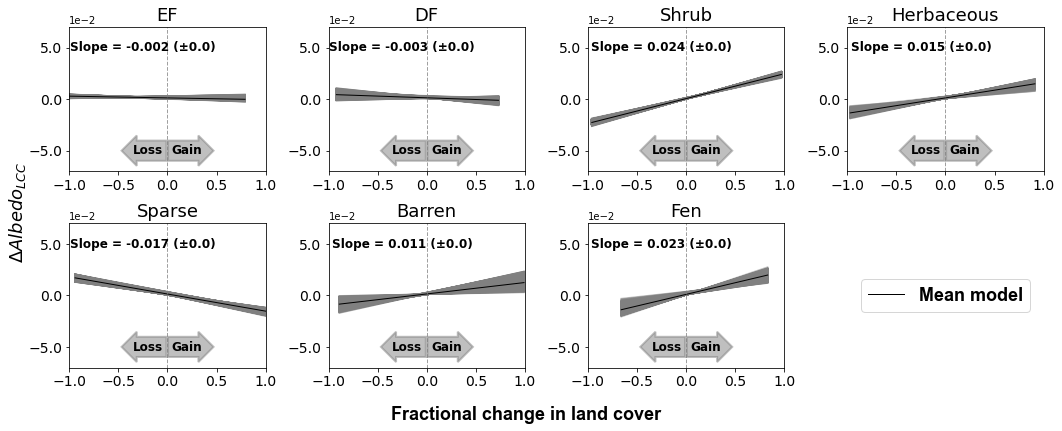

In [4]:
plt.close()
fig, axs = plt.subplots(2, 4, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
axs_counter = 0
t_list = []
for i in range(len(lc_names)):
    # Skip the bog and shallow and litteral classes due to very sparse
    # data points
    if (i == 7) | (i == 8) | ((i == 9)):
        continue
    print(f"Analyzing {lc_names[i]}")
    dlcc_tmp_clean = dlcc_clean.isel(LC=i)
    df = pd.DataFrame({
        "dlst": dlst_clean,
        "dalbedo": dalbedo_clean,
        "det": det_clean,
        # "w": weights_clean,
        "dlcc": dlcc_tmp_clean
    })
    df = df.dropna()

    # Bin data based on dLCC
    dlcc_bins = np.linspace(-1.01, 1, 202)
    gian_loss_bins = binning(df=df, bins=dlcc_bins, var="dalbedo")
    # Scatter plot of the gain/loss
    # axs[axs_counter].scatter(x=out[0], y=out[1], color="gray")
    x = gian_loss_bins[0]
    y = gian_loss_bins[1]
    sample_weights = gian_loss_bins[2].values
    boot_reg = bootstrap(x=x,
                         y=y,
                         sample_weights=sample_weights,
                         n=N_M,
                         seed=0)
    params = boot_reg[0]
    predicts = boot_reg[1]
    axs[axs_counter].plot(x, predicts, color="gray", alpha=0.5)
    mean_predicts = np.mean(predicts, axis=1)
    axs[axs_counter].plot(x,
                          mean_predicts,
                          color="black",
                          linewidth=1,
                          label='Mean model')
    slope_mean = np.round(params[0, ].mean(), 3)
    slope_std = np.round(params[0, ].std(), 2)
    intercept_mean = np.round(params[1, ].mean(), 2)
    intercept_std = np.round(params[1, ].std(), 2)
    eq_text = (f"Slope = {slope_mean}" + " (\u00B1" +
                f"{slope_std})")
    axs[axs_counter].set_title(lc_names[i],fontsize=18)
    axs[axs_counter].tick_params(labelsize=14)
    axs[axs_counter].axvline(0, ls='--', c="gray", linewidth=1,alpha=0.75)
    axs[axs_counter].text(-0.25,
                          0.05,
                          eq_text,
                          horizontalalignment='center',
                          verticalalignment='center',
                          fontsize=12,
                          fontweight="bold",
                          color="black")
    axs[axs_counter].set_xlim(-1, 1)
    axs[axs_counter].set_ylim(-3, 3)
    axs[axs_counter].text(0.2,
                          -0.05,
                          "Gain",
                          ha="center",
                          va="center",
                          size=12,
                          color="black",
                          fontweight="semibold",
                          bbox=dict(boxstyle="rarrow,pad=0.3",
                                    fc="gray",
                                    ec="gray",
                                    alpha=0.5,
                                    lw=2))
    axs[axs_counter].text(-0.2,
                          -0.05,
                          "Loss",
                          ha="center",
                          va="center",
                          size=12,
                          fontweight="semibold",
                          color="black",
                          bbox=dict(boxstyle="larrow,pad=0.3",
                                    fc="gray",
                                    ec="gray",
                                    alpha=0.5,
                                    lw=2))
    axs[axs_counter].set_xlim(-1, 1)
    axs[axs_counter].set_ylim(-0.07, 0.07)
    axs[axs_counter].yaxis.set_major_formatter(yfmt)
    axs_counter += 1

# Sorting out the legend
labels_handles = {
    label: handle
    for ax in fig.axes
    for handle, label in zip(*ax.get_legend_handles_labels())
}
# desired_legend_order = [
#     "Mean model", "EF", "DF", "Shrub", "Herbaceous", "Sparse", "Barren", "Fen",
#     "Water"
# ]
# reordered_labels_handles = {k: labels_handles[k] for k in desired_legend_order}
# plt.legend(
#     reordered_labels_handles.values(),
#     reordered_labels_handles.keys(),
#     bbox_to_anchor=(1, 1),
# )
bottom_right_ax = axs[-1]
bottom_right_ax.clear()  # clears the random data I plotted previously
bottom_right_ax.set_axis_off()  # removes the XY axes

leg = plt.legend(
    labels_handles.values(),
    labels_handles.keys(),
    # bbox_to_anchor=(1, 1),
    loc='center',
    prop={
        "family": "Arial",
        "weight": "bold",
        "size": 18
    },
)

pltfont = {'fontname': 'Arial'}
fig.supxlabel('Fractional change in land cover', fontsize=18, **pltfont,fontweight="bold")
fig.supylabel("$\Delta Albedo_{LCC}$", fontsize=18, **pltfont,fontweight="bold")
# fig.suptitle("A", x=0.02, y=0.85, size=30, **pltfont)
plt.tight_layout()
save(out_dir + "Annual_gain_loss_Albedo_Albers_CI_After_ERL_Revision.png")
